## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [ ]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 1.9 MB/s eta 0:00:00


In [6]:
import gdown
# train
url = "https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link"
output = 'train.csv'
gdown.download(url, output, quiet=False, fuzzy=True)

# test
url = "https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link"
output = 'test.csv'
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-
From (redirected): https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-&confirm=t&uuid=acf974ed-d672-455f-acf2-f6c19646b1c5
To: /content/train.csv
100%|██████████| 170M/170M [00:02<00:00, 57.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG
To: /content/test.csv
100%|██████████| 21.1M/21.1M [00:00<00:00, 47.2MB/s]


'test.csv'



# 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



## Библиотеки

In [41]:
import pickle
import dill
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import scipy.sparse as sp
from scipy.sparse.linalg import svds

import tensorflow as tf
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import shap

from tqdm import tqdm

## Загрузка данных и разбиение по времени

In [7]:
# Загрузка данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [8]:
train_df['last_watch_dt'] = pd.to_datetime(train_df['last_watch_dt'])
test_df['last_watch_dt'] = pd.to_datetime(test_df['last_watch_dt'])

In [9]:
# Определяем дату разделения (например, 80% данных для обучения, 20% для валидации)
split_date = train_df['last_watch_dt'].quantile(0.8)
train_stage_1 = train_df[train_df['last_watch_dt'] <= split_date].copy()
valid_stage_1 = train_df[train_df['last_watch_dt'] > split_date].copy()

## Кандидат-генераторы

In [2]:
# 2.1. Эвристическая (алгоритмичная) модель: на основе популярности айтемов
class MyHeuristicModel:
    def __init__(self, train_data):
        # Популярность айтемов – сумма меток target
        self.item_popularity = train_data.groupby('item_id')['target'].sum().to_dict()
        # Дефолтный скор – среднее значение популярности
        self.default_score = np.mean(list(self.item_popularity.values()))
        # Предвычисление топ-айтемов (для всех пользователей)
        self.top_items = sorted(self.item_popularity.keys(), key=lambda x: self.item_popularity.get(x, 0), reverse=True)

    def predict(self, user_id, item_id):
        # Если айтем не встречался – возвращаем дефолтное значение
        return self.item_popularity.get(item_id, self.default_score)

    def recommend(self, user_id, top_k=10):
        # Рекомендуем топ-K популярных айтемов
        return self.top_items[:top_k]

# 2.2. Матричная факторизация на основе SVD
class MyMatrixFactorization:
    def __init__(self, train_data, n_factors=20):
        self.n_factors = n_factors

        # Получаем уникальные идентификаторы пользователей и айтемов
        self.user_ids = train_data['user_id'].unique()
        self.item_ids = train_data['item_id'].unique()
        self.user_to_index = {user: idx for idx, user in enumerate(self.user_ids)}
        self.item_to_index = {item: idx for idx, item in enumerate(self.item_ids)}

        # Преобразуем данные target в тип float
        row = train_data['user_id'].map(self.user_to_index).values
        col = train_data['item_id'].map(self.item_to_index).values
        data = train_data['target'].values.astype(np.float32)  # Приводим к float
        shape = (len(self.user_ids), len(self.item_ids))

        # Создаем разреженную матрицу
        self.user_item_matrix = sp.coo_matrix((data, (row, col)), shape=shape).tocsr()

        # Выполняем SVD на разреженной матрице
        U, s, Vt = svds(self.user_item_matrix, k=n_factors)
        idx = np.argsort(s)[::-1]
        self.s = s[idx]
        self.U = U[:, idx]
        self.Vt = Vt[idx, :]

        # Вычисляем латентные факторы
        self.user_factors = self.U * self.s
        self.item_factors = self.Vt.T  # Транспонированная матрица латентных факторов айтемов

        self.default_score = 0.0

    def predict(self, user_id, item_id):
        if user_id in self.user_to_index and item_id in self.item_to_index:
            u_idx = self.user_to_index[user_id]
            i_idx = self.item_to_index[item_id]
            return np.dot(self.user_factors[u_idx], self.item_factors[i_idx])
        else:
            return self.default_score

    def recommend(self, user_id, top_k=10):
        if user_id in self.user_to_index:
            u_idx = self.user_to_index[user_id]
            scores = np.dot(self.item_factors, self.user_factors[u_idx])
            top_indices = np.argsort(scores)[-top_k:][::-1]
            return [self.item_ids[i] for i in top_indices]
        else:
            return list(self.item_ids)[:top_k]

# 2.3. Нейросетевая модель на основе Keras
class MyNeuralNetwork:
    def __init__(self, train_data, embedding_size=10, hidden_units=[32, 16], epochs=5, batch_size=256):
        # Получаем уникальные идентификаторы пользователей и айтемов
        self.users = train_data['user_id'].unique()
        self.items = train_data['item_id'].unique()
        self.n_users = len(self.users)
        self.n_items = len(self.items)
        self.user_to_index = {user: idx for idx, user in enumerate(self.users)}
        self.item_to_index = {item: idx for idx, item in enumerate(self.items)}

        # Определяем входы модели
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')

        # Слои эмбеддингов
        user_embedding = Embedding(input_dim=self.n_users, output_dim=embedding_size, name='user_embedding')(user_input)
        user_vec = Flatten()(user_embedding)
        item_embedding = Embedding(input_dim=self.n_items, output_dim=embedding_size, name='item_embedding')(item_input)
        item_vec = Flatten()(item_embedding)

        # Конкатенация эмбеддингов
        concat = Concatenate()([user_vec, item_vec])
        x = concat
        # Полносвязные слои
        for units in hidden_units:
            x = Dense(units, activation='relu')(x)
        # Линейный выходной слой – скор релевантности
        output = Dense(1, activation='linear')(x)

        self.model = Model(inputs=[user_input, item_input], outputs=output)
        self.model.compile(optimizer='adam', loss='mse')

        # Подготовка обучающих данных
        X_user = train_data['user_id'].map(self.user_to_index).values
        X_item = train_data['item_id'].map(self.item_to_index).values
        y = train_data['target'].values

        # Обучение модели
        self.model.fit([X_user, X_item], y, epochs=epochs, batch_size=batch_size, verbose=1)
        self.default_score = 0.0

    def predict(self, user_id, item_id):
        if (user_id in self.user_to_index) and (item_id in self.item_to_index):
            u = np.array([self.user_to_index[user_id]])
            i = np.array([self.item_to_index[item_id]])
            score = self.model.predict([u, i], verbose=0)
            return score[0][0]
        else:
            return self.default_score

    def recommend(self, user_id, top_k=10):
        if user_id in self.user_to_index:
            scores = {}
            for item in self.items:
                scores[item] = self.predict(user_id, item)
            top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
            return [item for item, score in top_items]
        else:
            return list(self.items)[:top_k]

## Метрики качества

In [3]:
def rbo(list1, list2, p=0.9):
    """
    Вычисляет Ranked Based Overlap (RBO) между двумя ранжированными списками
    """
    S, T = set(), set()
    rbo_sum = 0.0
    for d in range(1, max(len(list1), len(list2)) + 1):
        if d <= len(list1):
            S.add(list1[d-1])
        if d <= len(list2):
            T.add(list2[d-1])
        A_d = len(S.intersection(T))
        rbo_sum += A_d / d * (p ** (d-1))
    return (1 - p) * rbo_sum

def compute_coverage(model, users, all_items, top_k=10):
    """
    Вычисляет долю айтемов, рекомендованных хотя бы одному пользователю
    """
    recommended_items = set()
    for user in users:
        recommended_items.update(model.recommend(user, top_k))
    return len(recommended_items) / len(all_items)

def compute_diversity(recommendations, item_embeddings):
    """
    Вычисляет разнообразие списка рекомендаций по косинусному расстоянию между эмбеддингами
    Возвращает значение 1 - average_similarity
    """
    if len(recommendations) < 2:
        return 0.0
    sims = []
    for i in range(len(recommendations)):
        for j in range(i+1, len(recommendations)):
            emb1 = item_embeddings.get(recommendations[i])
            emb2 = item_embeddings.get(recommendations[j])
            if emb1 is not None and emb2 is not None:
                sim = cosine_similarity([emb1], [emb2])[0][0]
                sims.append(sim)
    avg_sim = np.mean(sims) if sims else 0.0
    return 1 - avg_sim

In [10]:
# Инициализация и (при необходимости) обучение моделей
my_heuristic_model = MyHeuristicModel(train_stage_1)

In [11]:
my_matrix_factorization = MyMatrixFactorization(train_stage_1, n_factors=3)

In [12]:
my_neural_network = MyNeuralNetwork(train_stage_1, embedding_size=10, hidden_units=[32,16], epochs=5, batch_size=256)

Epoch 1/5
15392/15392 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - loss: 0.2128
Epoch 2/5
15392/15392 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.1672
Epoch 3/5
15392/15392 ━━━━━━━━━━━━━━━━━━━━ 89s 4ms/step - loss: 0.1459
Epoch 4/5
15392/15392 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.1305
Epoch 5/5
15392/15392 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - loss: 0.1195


In [ ]:
# Пример использования моделей для пары (user, item)
user_example = train_stage_1.iloc[0]['user_id']
item_example = train_stage_1.iloc[0]['item_id']

score_heuristic = my_heuristic_model.predict(user_example, item_example)
score_mf = my_matrix_factorization.predict(user_example, item_example)
score_nn = my_neural_network.predict(user_example, item_example)

print("Heuristic Model Score:", score_heuristic)
print("Matrix Factorization Score:", score_mf)
print("Neural Network Score:", score_nn)

# Пример: получение рекомендаций для конкретного пользователя (top-10)
top_k = 10
recs_heuristic = my_heuristic_model.recommend(user_example, top_k=top_k)
recs_mf = my_matrix_factorization.recommend(user_example, top_k=top_k)
recs_nn = my_neural_network.recommend(user_example, top_k=top_k)

print("Heuristic Model Recommendations:", recs_heuristic)
print("Matrix Factorization Recommendations:", recs_mf)
print("Neural Network Recommendations:", recs_nn)

Heuristic Model Score: 301
Matrix Factorization Score: 1.1864528e-06
Neural Network Score: 0.8355751
Heuristic Model Recommendations: [15297, 13865, 10440, 9728, 3734, 4151, 142, 8636, 6809, 11237]
Matrix Factorization Recommendations: [np.int64(13865), np.int64(9728), np.int64(15297), np.int64(3734), np.int64(142), np.int64(8636), np.int64(4151), np.int64(11237), np.int64(1844), np.int64(7417)]
Neural Network Recommendations: [np.int64(5081), np.int64(4344), np.int64(13168), np.int64(3044), np.int64(4685), np.int64(6072), np.int64(8180), np.int64(15448), np.int64(15517), np.int64(7793)]


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


# 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

Этап 1: Определяем дату кандидата (первый день valid_stage_1) и пороговую дату (cutoff_date = candidate_day – 1 день). На основе исторических данных до cutoff_date вычисляем агрегированные признаки для пользователей и айтемов.

Этап 2: Группируя исторические данные по паре (user, item), вычисляем агрегаты (количество, среднее watched_pct, суммарное время) и на их основе рассчитываем отношения и разницу между агрегированными значениями пользователей и айтемов. Это дает 6 признаков на уровне взаимодействия.

Этап 3: Объединяем все рассчитанные признаки с кандидатом (например, valid_stage_1). Таким образом, для каждой пары (user, item) доступны 2 пользовательских, 2 айтемных и 6 взаимодействий – всего 10 признаков. При этом все расчеты выполняются без утечки (используются только данные до cutoff_date).

## Сбор признаков для обучения (train_df_with_features)

In [14]:
# Определяем первый день валидационного этапа (candidate day для обучения)
train_candidate_day = valid_stage_1['last_watch_dt'].min()
# Чтобы не допустить утечки, используем данные до предыдущего дня
cutoff_train = train_candidate_day - timedelta(days=1)
print("Train candidate day:", train_candidate_day)
print("Train features cutoff:", cutoff_train)

Train candidate day: 2021-07-27 00:00:00
Train features cutoff: 2021-07-26 00:00:00


In [15]:
# Исторические данные для обучения – все записи до cutoff_train
historical_train = train_stage_1[train_stage_1['last_watch_dt'] <= cutoff_train].copy()

# 1. Признаки для пользователя (2 фичи)
user_agg_train = historical_train.groupby('user_id').agg(
    user_avg_watched_pct=('watched_pct', 'mean'),
    user_interaction_count=('user_id', 'count')
).reset_index()

# 2. Признаки для айтема (2 фичи)
item_agg_train = historical_train.groupby('item_id').agg(
    item_avg_watched_pct=('watched_pct', 'mean'),
    item_interaction_count=('item_id', 'count')
).reset_index()

# 3. Признаки для взаимосвязи user-item (6 фичей)
ui_agg_train = historical_train.groupby(['user_id', 'item_id']).agg(
    ui_interaction_count=('user_id', 'count'),
    ui_avg_watched_pct=('watched_pct', 'mean'),
    ui_total_dur_sum=('total_dur', 'sum')
).reset_index()

# Фича: доля взаимодействий данной пары от общего числа взаимодействий пользователя
ui_agg_train = ui_agg_train.merge(user_agg_train, on='user_id', how='left')
ui_agg_train['ui_ratio_count'] = ui_agg_train['ui_interaction_count'] / ui_agg_train['user_interaction_count']
ui_agg_train.drop(columns=['user_interaction_count'], inplace=True)

# Фича: разница между средним watched_pct пользователя и айтема
ui_agg_train = ui_agg_train.merge(item_agg_train, on='item_id', how='left')
ui_agg_train['ui_diff_avg_watched'] = ui_agg_train['user_avg_watched_pct'] - ui_agg_train['item_avg_watched_pct']

# Фича: доля суммарного времени просмотра по паре к общему времени просмотра пользователя
user_total_dur_train = historical_train.groupby('user_id')['total_dur'].sum().reset_index().rename(
    columns={'total_dur': 'user_total_dur_sum'}
)
ui_agg_train = ui_agg_train.merge(user_total_dur_train, on='user_id', how='left')
ui_agg_train['ui_ratio_total_dur'] = ui_agg_train['ui_total_dur_sum'] / ui_agg_train['user_total_dur_sum']

# Итоговая выборка для обучения: берем все кандидаты из valid_stage_1 и объединяем с рассчитанными признаками
train_df_with_features = valid_stage_1.copy()
train_df_with_features = train_df_with_features.merge(user_agg_train, on='user_id', how='left')
train_df_with_features = train_df_with_features.merge(item_agg_train, on='item_id', how='left')
train_df_with_features = train_df_with_features.merge(
    ui_agg_train[['user_id', 'item_id', 'ui_interaction_count', 'ui_avg_watched_pct',
                  'ui_total_dur_sum', 'ui_ratio_count', 'ui_diff_avg_watched', 'ui_ratio_total_dur']],
    on=['user_id', 'item_id'], how='left'
)

# Заполним пропуски (например, если для какой-то пары исторических данных нет)
train_df_with_features.fillna(0, inplace=True)

## Сбор признаков для теста (test_df_with_features)

In [16]:
# Определяем первый день тестового набора
test_candidate_day = test_df['last_watch_dt'].min()
# Пороговая дата – день до начала теста, чтобы использовать только доступную историю
cutoff_test = test_candidate_day - timedelta(days=1)
print("Test candidate day:", test_candidate_day)
print("Test features cutoff:", cutoff_test)

Test candidate day: 2021-08-13 00:00:00
Test features cutoff: 2021-08-12 00:00:00


In [17]:
# Для теста будем использовать всю историю из train_stage_1 и valid_stage_1, которая до cutoff_test
historical_test = pd.concat([train_stage_1, valid_stage_1])
historical_test = historical_test[historical_test['last_watch_dt'] <= cutoff_test].copy()

# Признаки для пользователя (2 фичи)
user_agg_test = historical_test.groupby('user_id').agg(
    user_avg_watched_pct=('watched_pct', 'mean'),
    user_interaction_count=('user_id', 'count')
).reset_index()

# Признаки для айтема (2 фичи)
item_agg_test = historical_test.groupby('item_id').agg(
    item_avg_watched_pct=('watched_pct', 'mean'),
    item_interaction_count=('item_id', 'count')
).reset_index()

# Признаки для взаимосвязи user-item (6 фичей)
ui_agg_test = historical_test.groupby(['user_id', 'item_id']).agg(
    ui_interaction_count=('user_id', 'count'),
    ui_avg_watched_pct=('watched_pct', 'mean'),
    ui_total_dur_sum=('total_dur', 'sum')
).reset_index()

ui_agg_test = ui_agg_test.merge(user_agg_test, on='user_id', how='left')
ui_agg_test['ui_ratio_count'] = ui_agg_test['ui_interaction_count'] / ui_agg_test['user_interaction_count']
ui_agg_test.drop(columns=['user_interaction_count'], inplace=True)

ui_agg_test = ui_agg_test.merge(item_agg_test, on='item_id', how='left')
ui_agg_test['ui_diff_avg_watched'] = ui_agg_test['user_avg_watched_pct'] - ui_agg_test['item_avg_watched_pct']

user_total_dur_test = historical_test.groupby('user_id')['total_dur'].sum().reset_index().rename(
    columns={'total_dur': 'user_total_dur_sum'}
)
ui_agg_test = ui_agg_test.merge(user_total_dur_test, on='user_id', how='left')
ui_agg_test['ui_ratio_total_dur'] = ui_agg_test['ui_total_dur_sum'] / ui_agg_test['user_total_dur_sum']

# Итоговая выборка для теста: объединяем кандидатов из test_df с рассчитанными признаками
test_df_with_features = test_df.copy()
test_df_with_features = test_df_with_features.merge(user_agg_test, on='user_id', how='left')
test_df_with_features = test_df_with_features.merge(item_agg_test, on='item_id', how='left')
test_df_with_features = test_df_with_features.merge(
    ui_agg_test[['user_id', 'item_id', 'ui_interaction_count', 'ui_avg_watched_pct',
                 'ui_total_dur_sum', 'ui_ratio_count', 'ui_diff_avg_watched', 'ui_ratio_total_dur']],
    on=['user_id', 'item_id'], how='left'
)

# Заполним пропуски
test_df_with_features.fillna(0, inplace=True)

In [ ]:
train_df_with_features.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_avg_watched_pct,user_interaction_count,item_avg_watched_pct,item_interaction_count,ui_interaction_count,ui_avg_watched_pct,ui_total_dur_sum,ui_ratio_count,ui_diff_avg_watched,ui_ratio_total_dur
0,1038054,12356,2021-07-27,197,4.0,0,0.000000,0.0,63.081042,3492.0,0.0,0.0,0.0,0.0,0.0,0.0
1,765534,16166,2021-07-27,739,12.0,0,0.000000,1.0,58.331589,9361.0,0.0,0.0,0.0,0.0,0.0,0.0
2,799026,14264,2021-07-27,1500,17.0,0,50.428571,7.0,59.916101,2503.0,0.0,0.0,0.0,0.0,0.0,0.0
3,297066,16166,2021-07-27,4209,67.0,1,52.000000,2.0,58.331589,9361.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1014861,6106,2021-07-27,49790,63.0,1,76.967742,31.0,29.115684,899.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_df_with_features.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_avg_watched_pct,user_interaction_count,item_avg_watched_pct,item_interaction_count,ui_interaction_count,ui_avg_watched_pct,ui_total_dur_sum,ui_ratio_count,ui_diff_avg_watched,ui_ratio_total_dur
0,718866,6382,2021-08-13,10309,19.0,0,55.0,2.0,22.855103,4693.0,0.0,0.0,0.0,0.0,0.0,0.0
1,147119,13865,2021-08-13,1666,26.0,0,0.0,0.0,68.680699,111863.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1079425,4141,2021-08-13,774,10.0,0,37.7,10.0,59.019287,2748.0,0.0,0.0,0.0,0.0,0.0,0.0
3,810008,15297,2021-08-13,3,0.0,0,0.0,0.0,55.291089,175307.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1068123,10440,2021-08-13,492,0.0,0,0.0,0.0,47.377237,184054.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df_with_features.to_csv('train_df_with_features.csv')
test_df_with_features.to_csv('test_df_with_features.csv')


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






Решение:


Для каждой пары (user, item) из обучающей (valid_stage_1) и тестовой выборок добавляет дополнительные признаки – скоры трёх моделей, вычисленные на этапе 1.

Собирает итоговый датафрейм с признаками (10 агрегированных фич из этапа 2 плюс 3 скора моделей, итого 13 фич).

Обучает финальный ранкер с использованием XGBoost (как бинарного классификатора).

Строит графики важности признаков и рассчитывает SHAP values для интерпретации фич и проверки на наличие утечек (слишком доминирующая фича).

## Признаки

In [19]:
def add_model_scores_vectorized(df):
    # Эвристическая модель: берем скоры через map по словарю
    df['score_heuristic'] = df['item_id'].map(my_heuristic_model.item_popularity)
    df['score_heuristic'] = df['score_heuristic'].fillna(my_heuristic_model.default_score)

    # Матричная факторизация: векторизованный расчет скалярного произведения латентных векторов
    user_idx = df['user_id'].map(my_matrix_factorization.user_to_index)
    item_idx = df['item_id'].map(my_matrix_factorization.item_to_index)

    # Инициализируем массив для скоров
    mf_scores = np.zeros(len(df))

    # Определяем маску валидных пар
    valid_mask = user_idx.notnull() & item_idx.notnull()
    valid_user_idx = user_idx[valid_mask].astype(int).values
    valid_item_idx = item_idx[valid_mask].astype(int).values

    # Векторизованное скалярное произведение
    mf_scores[valid_mask] = np.sum(
        my_matrix_factorization.user_factors[valid_user_idx] *
        my_matrix_factorization.item_factors[valid_item_idx],
        axis=1
    )
    df['score_mf'] = mf_scores

    # Нейросетевая модель: собираем индексы и делаем батчевое предсказание
    nn_user_idx = df['user_id'].map(my_neural_network.user_to_index)
    nn_item_idx = df['item_id'].map(my_neural_network.item_to_index)
    nn_user_idx = nn_user_idx.fillna(-1).astype(int).values
    nn_item_idx = nn_item_idx.fillna(-1).astype(int).values
    valid_mask_nn = (nn_user_idx >= 0) & (nn_item_idx >= 0)

    nn_scores = np.full(len(df), my_neural_network.default_score, dtype=np.float32)
    if np.any(valid_mask_nn):
        X_user = nn_user_idx[valid_mask_nn]
        X_item = nn_item_idx[valid_mask_nn]
        preds = my_neural_network.model.predict([X_user, X_item], verbose=0).flatten()
        nn_scores[valid_mask_nn] = preds
    df['score_nn'] = nn_scores

    return df

In [20]:
train_df_with_features_preds = add_model_scores_vectorized(train_df_with_features)

In [21]:
test_df_with_features_preds = add_model_scores_vectorized(test_df_with_features)

## Обучение

In [22]:
# Определим список признаков
features = [
    "user_avg_watched_pct", "user_interaction_count",
    "item_avg_watched_pct", "item_interaction_count",
    "ui_interaction_count", "ui_avg_watched_pct",
    "ui_total_dur_sum", "ui_ratio_count",
    "ui_diff_avg_watched", "ui_ratio_total_dur",
    "score_heuristic", "score_mf", "score_nn"
]

# Подготовка обучающих данных (valid_stage_1 с признаками)
X_train = train_df_with_features_preds[features]
y_train = train_df_with_features_preds['target']

# Инициализация и обучение модели XGBoost
final_ranker = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
final_ranker.fit(X_train, y_train)

# Оценка качества на обучающем наборе
y_pred_proba = final_ranker.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred_proba)
print("Train AUC:", auc)

Train AUC: 0.7246452406074884


In [23]:
import pickle

with open('final_ranker.pkl', 'wb') as f:
    pickle.dump(final_ranker, f)

print("Модель final_ranker успешно сохранена в файл final_ranker.pkl")

Модель final_ranker успешно сохранена в файл final_ranker.pkl


## Интерпретация модели

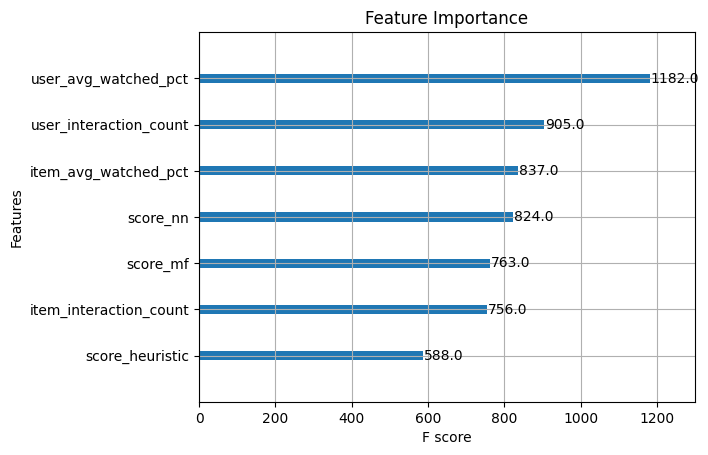

In [ ]:
# Визуализация важности признаков
xgb.plot_importance(final_ranker, max_num_features=features.__len__())
plt.title("Feature Importance")
plt.show()

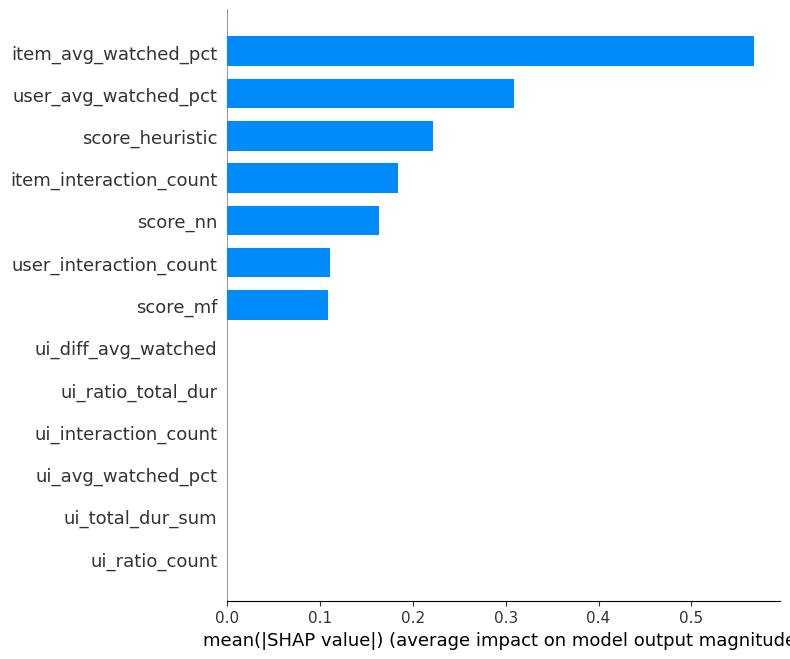

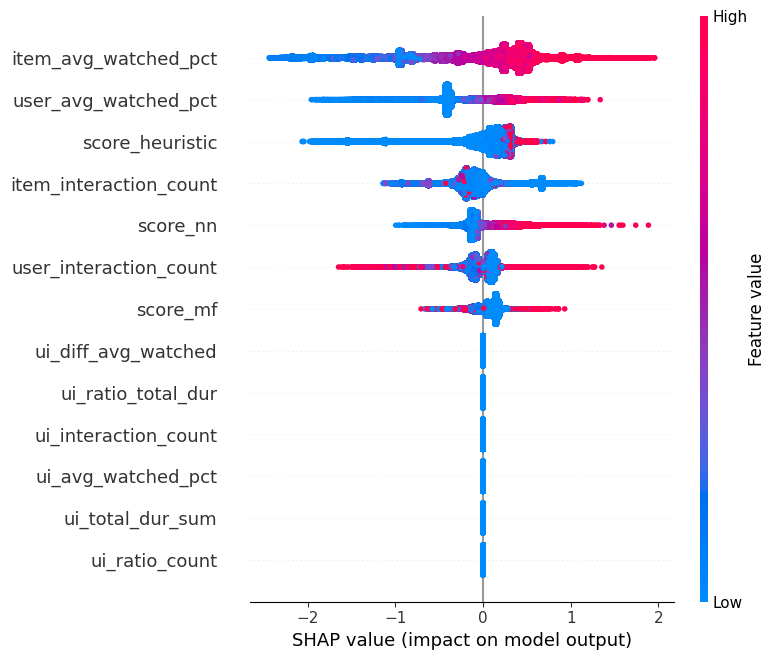

In [ ]:
# Расчет SHAP values
explainer = shap.TreeExplainer(final_ranker)
shap_values = explainer.shap_values(X_train)

# График суммарного влияния фич (bar plot)
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)

# График распределения влияния фич для нескольких примеров
shap.summary_plot(shap_values, X_train, feature_names=features)

In [ ]:
train_df_with_features_preds.to_csv('train_df_with_features_preds.csv')
test_df_with_features_preds.to_csv('test_df_with_features_preds.csv')


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [24]:
!pip install -q dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00


In [26]:
# Обучение моделей первого уровня на всех данных (train+test)
# Объединяем все данные
all_data = pd.concat([train_stage_1, valid_stage_1, test_df], ignore_index=True)
all_data['last_watch_dt'] = pd.to_datetime(all_data['last_watch_dt'])

In [ ]:
all_data = pd.read_csv('all_data.csv', parse_dates=['last_watch_dt'])

In [ ]:
# Обучаем модели первого уровня на всех данных
my_heuristic_model_all = MyHeuristicModel(all_data)
my_matrix_factorization_all = MyMatrixFactorization(all_data, n_factors=5)
my_neural_network_all = MyNeuralNetwork(all_data, embedding_size=10, hidden_units=[32, 16], epochs=3, batch_size=256)

Epoch 1/3
21389/21389 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 0.2093
Epoch 2/3
21389/21389 ━━━━━━━━━━━━━━━━━━━━ 124s 4ms/step - loss: 0.1686
Epoch 3/3
21389/21389 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 0.1500


In [ ]:
# Сохраняем эвристическую модель
with open('heuristic_model_all.pkl', 'wb') as f:
    dill.dump(my_heuristic_model_all, f)

import dill

with open('matrix_factorization_all.pkl', 'wb') as f:
    dill.dump(my_matrix_factorization_all, f)

# Сохраняем нейросетевую модель (Keras)
my_neural_network_all.model.save('neural_network_all.h5')

print("Модели успешно обучены и сохранены!")

Модели успешно обучены и сохранены!


In [ ]:
# Генерация N кандидатов для каждого пользователя по каждой модели

N = 5 # число кандидатов, генерируемых каждой моделью для каждого пользователя

users_all = all_data['user_id'].unique()
candidate_dict = {}
for user in tqdm(users_all):
    # Для каждого пользователя получаем кандидатов из каждой модели
    cand1 = my_heuristic_model_all.recommend(user, top_k=N)
    cand2 = my_matrix_factorization_all.recommend(user, top_k=N)
    # cand3 = my_neural_network_all.recommend(user, top_k=N)
    # Объединяем и удаляем дубли
    all_candidates = list(set(cand1 + cand2))
    candidate_dict[user] = all_candidates

100%|██████████| 962151/962151 [05:59<00:00, 2676.36it/s]


In [ ]:
# Формируем DataFrame кандидатов (каждая строка – пара (user, item))
candidate_rows = []
for user, items in candidate_dict.items():
    for item in items:
        candidate_rows.append({'user_id': user, 'item_id': item})
candidates_df = pd.DataFrame(candidate_rows)

In [ ]:
all_data.to_csv('all_data.csv', index=False)

In [ ]:
import pickle

with open("candidate_dict.pkl", "wb") as f:
    pickle.dump(candidate_dict, f)

In [ ]:
candidates_df.to_csv('candidates_df.csv')

## Скоры

In [ ]:
!pip install -q dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
candidates_df = pd.read_csv('candidates_df.csv', index_col=0)

In [ ]:
candidates_df.head()

,user_id,item_id
0,310745,9728
1,310745,15297
2,310745,10440
3,310745,13865
4,310745,142


In [ ]:
def add_model_scores_vectorized_candidates(df):
    # Эвристическая модель: маппинг из словаря популярности
    df['score_heuristic'] = df['item_id'].map(my_heuristic_model_all.item_popularity)
    df['score_heuristic'] = df['score_heuristic'].fillna(my_heuristic_model_all.default_score)

    # Матричная факторизация: векторное скалярное произведение латентных факторов
    user_idx = df['user_id'].map(my_matrix_factorization_all.user_to_index)
    item_idx = df['item_id'].map(my_matrix_factorization_all.item_to_index)
    mf_scores = np.zeros(len(df))
    valid_mask = user_idx.notnull() & item_idx.notnull()
    valid_user_idx = user_idx[valid_mask].astype(int).values
    valid_item_idx = item_idx[valid_mask].astype(int).values
    mf_scores[valid_mask] = np.sum(
        my_matrix_factorization_all.user_factors[valid_user_idx] *
        my_matrix_factorization_all.item_factors[valid_item_idx],
        axis=1
    )
    df['score_mf'] = mf_scores

    # Нейросетевая модель: батчевое предсказание
    nn_user_idx = df['user_id'].map(my_neural_network_all.user_to_index)
    nn_item_idx = df['item_id'].map(my_neural_network_all.item_to_index)
    nn_user_idx = nn_user_idx.fillna(-1).astype(int).values
    nn_item_idx = nn_item_idx.fillna(-1).astype(int).values
    valid_mask_nn = (nn_user_idx >= 0) & (nn_item_idx >= 0)
    nn_scores = np.full(len(df), my_neural_network_all.default_score, dtype=np.float32)
    if np.any(valid_mask_nn):
        X_user = nn_user_idx[valid_mask_nn]
        X_item = nn_item_idx[valid_mask_nn]
        # Используем predict батчами, если размер батча слишком большой, можно дополнительно разбить
        preds = my_neural_network_all.model.predict([X_user, X_item], verbose=0).flatten()
        nn_scores[valid_mask_nn] = preds
    df['score_nn'] = nn_scores

    return df

def add_model_scores_in_batches(df, batch_size=10000):
    results = []
    n = len(df)
    for i in tqdm(range(0, n, batch_size), desc="Обработка батчей"):
        batch = df.iloc[i:i+batch_size].copy()
        batch = add_model_scores_vectorized_candidates(batch)
        results.append(batch)
    return pd.concat(results, ignore_index=True)

In [ ]:
# Применяем функцию по батчам к DataFrame кандидатов
candidates_df_res = add_model_scores_in_batches(candidates_df, batch_size=100000)

Обработка батчей: 100%|██████████| 82/82 [13:40<00:00, 10.00s/it]


In [ ]:
candidates_df_res.to_csv('candidates_df_res.csv')

In [ ]:
all_data = pd.read_csv('all_data.csv')

In [27]:
candidates_df_res = pd.read_csv('candidates_df_res.csv', index_col=0)

In [28]:
# сбор признаков для кандидатов на основе всех данных

# Признаки для пользователя
user_agg_all = all_data.groupby('user_id').agg(
    user_avg_watched_pct=('watched_pct', 'mean'),
    user_interaction_count=('user_id', 'count')
).reset_index()

# Признаки для айтема
item_agg_all = all_data.groupby('item_id').agg(
    item_avg_watched_pct=('watched_pct', 'mean'),
    item_interaction_count=('item_id', 'count')
).reset_index()

# Признаки для взаимосвязи user-item
ui_agg_all = all_data.groupby(['user_id', 'item_id']).agg(
    ui_interaction_count=('user_id', 'count'),
    ui_avg_watched_pct=('watched_pct', 'mean'),
    ui_total_dur_sum=('total_dur', 'sum')
).reset_index()

ui_agg_all = ui_agg_all.merge(user_agg_all, on='user_id', how='left')
ui_agg_all['ui_ratio_count'] = ui_agg_all['ui_interaction_count'] / ui_agg_all['user_interaction_count']
ui_agg_all = ui_agg_all.merge(item_agg_all, on='item_id', how='left')
ui_agg_all['ui_diff_avg_watched'] = ui_agg_all['user_avg_watched_pct'] - ui_agg_all['item_avg_watched_pct']
user_total_dur_all = all_data.groupby('user_id')['total_dur'].sum().reset_index().rename(columns={'total_dur': 'user_total_dur_sum'})
ui_agg_all = ui_agg_all.merge(user_total_dur_all, on='user_id', how='left')
ui_agg_all['ui_ratio_total_dur'] = ui_agg_all['ui_total_dur_sum'] / ui_agg_all['user_total_dur_sum']

In [ ]:
candidates_df_res

,user_id,item_id,score_heuristic,score_mf,score_nn
0,310745,9728,74589,0.000672,0.783840
1,310745,15297,101080,-0.000027,0.744274
2,310745,10440,87957,-0.000261,0.618908
3,310745,13865,80859,0.000298,0.903497
4,310745,142,26761,0.000292,0.739772
...,...,...,...,...,...
8194563,100875,3016,0,0.000000,0.189548
8194564,100875,15476,0,0.000000,0.249106
8194565,100875,3734,52972,0.000000,0.223070
8194566,100875,13373,387,0.000000,0.286105


In [29]:
# Объединяем признаки кандидатов
candidates_df_res = candidates_df_res.merge(user_agg_all, on='user_id', how='left')
candidates_df_res = candidates_df_res.merge(item_agg_all, on='item_id', how='left')
candidates_df_res = candidates_df_res.merge(
    ui_agg_all[['user_id', 'item_id', 'ui_interaction_count', 'ui_avg_watched_pct',
                'ui_total_dur_sum', 'ui_ratio_count', 'ui_diff_avg_watched', 'ui_ratio_total_dur']],
    on=['user_id', 'item_id'], how='left'
)
candidates_df_res.fillna(0, inplace=True)

# Итоговый набор признаков (10 агрегированных + 3 скора моделей)
features = [
    "user_avg_watched_pct", "user_interaction_count",
    "item_avg_watched_pct", "item_interaction_count",
    "ui_interaction_count", "ui_avg_watched_pct",
    "ui_total_dur_sum", "ui_ratio_count",
    "ui_diff_avg_watched", "ui_ratio_total_dur",
    "score_heuristic", "score_mf", "score_nn"
]

In [32]:
# Инференс финального ранкера: пропускаем кандидатов через бустинг и оставляем топ-k
X_candidates = candidates_df_res[features]
candidates_df_res['final_score'] = final_ranker.predict_proba(X_candidates)[:, 1]

k = 10  # оставляем топ-10 рекомендаций для каждого пользователя
final_recommendations = {}
for user, group in tqdm(candidates_df_res.groupby('user_id')):
    top_k_items = group.sort_values('final_score', ascending=False).head(k)['item_id'].tolist()
    final_recommendations[user] = top_k_items

100%|██████████| 190953/190953 [01:38<00:00, 1931.57it/s]


In [37]:
# Вычисление разнообразия (Diversity) и построение графика Diversity(k)
# В качестве эмбеддингов для айтемов возьмём латентные факторы из матричной факторизации
mf_item_embeddings = {
    item: my_matrix_factorization_all.item_factors[
        my_matrix_factorization_all.item_to_index[item]
    ]
    for item in my_matrix_factorization_all.item_ids
}

def compute_diversity_vectorized(item_list, embeddings):
    """
    Вычисляет Diversity для списка айтемов векторизованно
    Если эмбеддинг отсутствует для айтема, он пропускается
    Diversity = 1 - (среднее сходство по всем парам)
    """
    if len(item_list) < 2:
        return 0.0

    # Получаем эмбеддинги для айтемов, пропуская отсутствующие
    vectors = [embeddings.get(item) for item in item_list if embeddings.get(item) is not None]
    if len(vectors) < 2:
        return 0.0
    vectors = np.vstack(vectors)  # Форма: (n, dim)

    # Вычисляем матрицу косинусного сходства
    sim_matrix = cosine_similarity(vectors)
    n = sim_matrix.shape[0]
    # Извлекаем верхнюю треугольную часть без диагонали
    upper_tri_indices = np.triu_indices(n, k=1)
    upper_values = sim_matrix[upper_tri_indices]
    avg_sim = np.mean(upper_values)
    return 1 - avg_sim

In [39]:
# Предварительно создаём список групп по пользователям, чтобы знать общее число пользователей
user_groups = list(candidates_df_res.groupby('user_id'))

diversity_results = {}
for k_val in tqdm(range(1, 21, 3), desc="Расчёт Diversity для разных k"):
    diversity_per_user = []
    # Вложенный tqdm для обработки пользователей
    for user, group in user_groups:
        top_k_items = group.sort_values('final_score', ascending=False).head(k_val)['item_id'].tolist()
        diversity_per_user.append(compute_diversity_vectorized(top_k_items, mf_item_embeddings))
    diversity_results[k_val] = np.mean(diversity_per_user)

Расчёт Diversity для разных k: 100%|██████████| 7/7 [14:05<00:00, 120.77s/it]


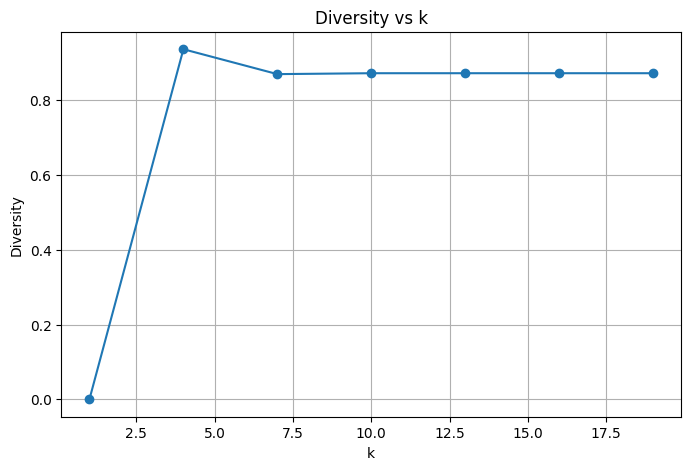

In [40]:
# Построение графика Diversity(k)
plt.figure(figsize=(8, 5))
plt.plot(list(diversity_results.keys()), list(diversity_results.values()), marker='o')
plt.xlabel('k')
plt.ylabel('Diversity')
plt.title('Diversity vs k')
plt.grid(True)
plt.show()

При значениях k, превышающих 5–7, метрика Diversity достигает устойчивых значений, что говорит о том, что добавление дополнительных айтемов не приводит к значительному снижению разнообразия рекомендаций

Высокие значения Diversity (в диапазоне 0.8–0.9) для оптимальных значений k свидетельствуют о том, что система способна выдавать рекомендации, которые существенно различаются друг от друга, что является положительным признаком с точки зрения пользовательского опыта и предотвращения эффекта «фильтровых пузырей»